## Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Scaling
from sklearn.preprocessing import MinMaxScaler

 #Correlation Heatmap
from matplotlib.colors import LinearSegmentedColormap

#Statistical Test
from scipy import stats
from sklearn.impute import SimpleImputer

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import Ridge

pd.set_option('display.max_columns', None)

In [21]:
# You can download the data in the source that is linked above the table of contents

# Read in the data
X_train_encoded = pd.read_csv('../project_data/X_train_encoded.csv', delimiter=',', index_col=0)
X_val_encoded = pd.read_csv('../project_data/X_val_encoded.csv', delimiter=',', index_col=0)

y_train = pd.read_csv('../project_data/y_train.csv',delimiter=',', index_col=0)
y_val= pd.read_csv('../project_data/y_val.csv', delimiter=',', index_col=0)

X_test_encoded = pd.read_csv('../project_data/X_test_encoded.csv',index_col=0)

## 1. Separate numerical and categorical

In [22]:
claim_injury_type_mapping = {
    '4. TEMPORARY': 4-1,
    '2. NON-COMP': 2-1,
    '5. PPD SCH LOSS': 5-1,
    '3. MED ONLY': 3-1,
    '6. PPD NSL': 6-1,
    '1. CANCELLED': 1-1,
    '8. DEATH':8-1,
    '7. PTD': 7-1
}

y_train_encoded = y_train['Claim Injury Type'].map(claim_injury_type_mapping)
y_val_encoded = y_val['Claim Injury Type'].map(claim_injury_type_mapping)

> Separate columns in numerical and categorical

In [23]:
num_columns = ['Age at Injury', 'IME-4 Count', 'Number of Dependents',
               'Days_between_Assembly Date_Accident Date_log',
               'Days_between_C-2 Date_Accident Date_log', 'Average Weekly Wage_log',
               'Industry Code_encoded_5. PPD SCH LOSS',
               'Industry Code_encoded_2. NON-COMP',
               'Industry Code_encoded_3. MED ONLY',
               'Industry Code_encoded_4. TEMPORARY',
               'Industry Code_encoded_1. CANCELLED', 'Industry Code_encoded_8. DEATH',
               'Industry Code_encoded_6. PPD NSL', 'Industry Code_encoded_7. PTD',
               'WCIO Cause of Injury Code_encoded_5. PPD SCH LOSS',
               'WCIO Cause of Injury Code_encoded_2. NON-COMP',
               'WCIO Cause of Injury Code_encoded_3. MED ONLY',
               'WCIO Cause of Injury Code_encoded_4. TEMPORARY',
               'WCIO Cause of Injury Code_encoded_1. CANCELLED',
               'WCIO Cause of Injury Code_encoded_8. DEATH',
               'WCIO Cause of Injury Code_encoded_6. PPD NSL',
               'WCIO Cause of Injury Code_encoded_7. PTD',
               'WCIO Nature of Injury Code_encoded_5. PPD SCH LOSS',
               'WCIO Nature of Injury Code_encoded_2. NON-COMP',
               'WCIO Nature of Injury Code_encoded_3. MED ONLY',
               'WCIO Nature of Injury Code_encoded_4. TEMPORARY',
               'WCIO Nature of Injury Code_encoded_1. CANCELLED',
               'WCIO Nature of Injury Code_encoded_8. DEATH',
               'WCIO Nature of Injury Code_encoded_6. PPD NSL',
               'WCIO Nature of Injury Code_encoded_7. PTD',
               'WCIO Part Of Body Code_encoded_5. PPD SCH LOSS',
               'WCIO Part Of Body Code_encoded_2. NON-COMP',
               'WCIO Part Of Body Code_encoded_3. MED ONLY',
               'WCIO Part Of Body Code_encoded_4. TEMPORARY',
               'WCIO Part Of Body Code_encoded_1. CANCELLED',
               'WCIO Part Of Body Code_encoded_8. DEATH',
               'WCIO Part Of Body Code_encoded_6. PPD NSL',
               'WCIO Part Of Body Code_encoded_7. PTD']

cat_columns = ['Alternative Dispute Resolution_binary', 
               'COVID-19 Indicator_binary',
               'Attorney/Representative_binary',
               'Carrier Type_Self-insured Private Entity',
               'Carrier Type_Self-insured Public Entity', 
               'Carrier Type_Special Funds',
               'Carrier Type_State Insurance Fund', 
               'C-3 Date_nabinary',
               'First Hearing Date_nabinary', 
               'Accident Date_Season_Spring',
               'Accident Date_Season_Summer', 
               'Accident Date_Season_Winter']


# Create subsets
X_train_num = X_train_encoded[num_columns]
X_train_cat = X_train_encoded[cat_columns]

X_val_num = X_val_encoded[num_columns]
X_val_cat = X_val_encoded[cat_columns]

X_test_num=X_test_encoded[num_columns]
X_test_cat=X_test_encoded[cat_columns]

### 1.1 Smooth

In [6]:
lambda_smooth = 0.1  # Smoothing parameter
global_mean = y_train_encoded.mean()  # Global mean of the target variable

# List of features to smooth
to_smooth = [
    'WCIO Part Of Body Code_encoded_8. DEATH',
    'WCIO Part Of Body Code_encoded_6. PPD NSL',
    'WCIO Part Of Body Code_encoded_7. PTD',
    'WCIO Nature of Injury Code_encoded_8. DEATH',
    'WCIO Nature of Injury Code_encoded_6. PPD NSL',
    'WCIO Nature of Injury Code_encoded_7. PTD',
    'WCIO Cause of Injury Code_encoded_8. DEATH',
    'WCIO Cause of Injury Code_encoded_6. PPD NSL',
    'WCIO Cause of Injury Code_encoded_7. PTD',
    'Industry Code_encoded_8. DEATH',
    'Industry Code_encoded_6. PPD NSL', 
    'Industry Code_encoded_7. PTD'
]

# Apply smoothing for each column in the to_smooth list
for column in to_smooth:
    if column in X_train_num.columns:  # Check if column exists in the DataFrame
        # Get unique categories in the column
        unique_categories = X_train_num[column].unique()
        
        # Apply smoothing for each category
        for category in unique_categories:
            # Get the target values for the current category
            category_target_values = y_train_encoded[X_train_num[column] == category]
            
            # Compute the category mean (mean target value for this category)
            category_mean = category_target_values.mean()
            
            # Number of instances in this category (N_i)
            N_i = len(category_target_values)
            
            # Apply the smoothing formula
            smoothed_value = (N_i * category_mean + lambda_smooth * global_mean) / (N_i + lambda_smooth)
            
            # Replace the category with the smoothed value using .loc to avoid SettingWithCopyWarning
            X_train_num.loc[X_train_num[column] == category, column] = smoothed_value
    else:
        print(f"Column {column} not found in the DataFrame!")

# After smoothing, inspect the DataFrame to confirm
print(X_train_num.head())


                  Age at Injury  IME-4 Count  Number of Dependents  \
Claim Identifier                                                     
5506797                    36.0          0.0                   4.0   
5481216                    48.0          0.0                   5.0   
5520188                    40.0          1.0                   6.0   
5748412                    54.0          0.0                   1.0   
5653867                    40.0          0.0                   0.0   

                  Days_between_Assembly Date_Accident Date_log  \
Claim Identifier                                                 
5506797                                               4.644391   
5481216                                               4.127134   
5520188                                               2.484907   
5748412                                               1.386294   
5653867                                               1.791759   

                  Days_between_C-2 Date_Accide

Convert y_train dataframe to series

In [27]:
y = y_train.squeeze()  # Converts a DataFrame with one column to a Series

In [7]:
# Percentage distribution of each class in the target variable
class_percentage = y.value_counts(normalize=True) * 100
print(class_percentage)


Claim Injury Type
2. NON-COMP        51.059463
4. TEMPORARY       25.559901
3. MED ONLY        12.014986
5. PPD SCH LOSS     8.460806
1. CANCELLED        2.067928
6. PPD NSL          0.738203
8. DEATH            0.081798
7. PTD              0.016915
Name: proportion, dtype: float64


## 2. Feature selection before encoding

> Use a combination of chi-square test and cramer's v to determine which categorical variables to keep.

In [31]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency

def cramers_v(X, y):
    # Create the contingency table
    df_contingency = pd.crosstab(X, y)
    
    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(df_contingency.values)
    
    # Calculate Cramér's V
    n = df_contingency.sum().sum()  # Total number of observations
    min_dim = min(df_contingency.shape) - 1  # Min between number of rows and columns - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))  # Cramér's V formula
    
    return cramers_v

# Example for X_train_cat (categorical features) and y_train (target)
# Perform Chi-square test
chi2_values, p_values = chi2(X_train_cat, y)

# Create a DataFrame with Chi-square results
chi2_results = pd.DataFrame({
    'Column': X_train_cat.columns,
    'Chi2': chi2_values.round(5),
    'p-value': p_values.round(5)
})

# Calculate Cramér's V for each feature
cramers_v_values = []
for var in X_train_cat.columns:
    v = cramers_v(X_train_cat[var], y)
    cramers_v_values.append(v)

# Add Cramér's V results to the DataFrame
chi2_results['Cramér\'s V'] = cramers_v_values

# Set threshold for Cramér's V (e.g., 0.1 for weak association, 0.3 for moderate, etc.)
cramers_v_threshold = 0.25

# Filter features based on p-value < 0.05 (Chi-square) and strong association (Cramér's V)
important_features = chi2_results[(chi2_results['p-value'] < 0.05) & (chi2_results['Cramér\'s V'] >= cramers_v_threshold)]

# Features to consider removing (p-value < 0.05 but weak association)
remove_features = chi2_results[(chi2_results['p-value'] < 0.05) & (chi2_results['Cramér\'s V'] < cramers_v_threshold)]

# Features with p-value >= 0.05 (Chi-square) can generally be discarded
not_important_features = chi2_results[chi2_results['p-value'] >= 0.05]

# Print results
print("Important Features (p-value < 0.05 & Cramér's V >= 0.25):")
print(important_features[['Column', 'Chi2', 'p-value', 'Cramér\'s V']])

print("\nFeatures to Consider Removing (p-value < 0.05 but weak Cramér's V < 0.25):")
print(remove_features[['Column', 'Chi2', 'p-value', 'Cramér\'s V']])

print("\nNot Important Features (p-value >= 0.05):")
print(not_important_features[['Column', 'Chi2', 'p-value']])


Important Features (p-value < 0.05 & Cramér's V >= 0.25):
                           Column          Chi2  p-value  Cramér's V
2  Attorney/Representative_binary  102697.45907      0.0    0.614944
7               C-3 Date_nabinary   61136.62719      0.0    0.479025
8     First Hearing Date_nabinary   86976.53025      0.0    0.545735

Features to Consider Removing (p-value < 0.05 but weak Cramér's V < 0.25):
                                      Column        Chi2  p-value  Cramér's V
0      Alternative Dispute Resolution_binary  1684.14209  0.00000    0.065354
1                  COVID-19 Indicator_binary  3731.36438  0.00000    0.099469
3   Carrier Type_Self-insured Private Entity   843.21649  0.00000    0.048427
4    Carrier Type_Self-insured Public Entity  5846.21288  0.00000    0.137095
5                 Carrier Type_Special Funds   200.30486  0.00000    0.022507
6          Carrier Type_State Insurance Fund  4656.16457  0.00000    0.120804
9                Accident Date_Season_Spring

In [28]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# Assuming X_train_cat is your categorical feature set and y_train is the target
# For classification problems:
mi = mutual_info_classif(X_train_cat, y,discrete_features=True)

# Create a DataFrame with the results
mi_results = pd.DataFrame({
    'Feature': X_train_cat.columns,
    'Mutual Information': mi
})

# Sort the features by their mutual information score
mi_results = mi_results.sort_values(by='Mutual Information', ascending=False)

# Display the top features based on MI
print("Mutual Information Results:")
mi_results


Mutual Information Results:
                                     Feature  Mutual Information
2             Attorney/Representative_binary            0.202553
8                First Hearing Date_nabinary            0.159525
7                          C-3 Date_nabinary            0.117598
4    Carrier Type_Self-insured Public Entity            0.008494
6          Carrier Type_State Insurance Fund            0.007226
1                  COVID-19 Indicator_binary            0.006363
0      Alternative Dispute Resolution_binary            0.002981
3   Carrier Type_Self-insured Private Entity            0.001246
11               Accident Date_Season_Winter            0.000167
5                 Carrier Type_Special Funds            0.000148
9                Accident Date_Season_Spring            0.000074
10               Accident Date_Season_Summer            0.000057


In [32]:
mi_results

,Feature,Mutual Information
2,Attorney/Representative_binary,0.202553
8,First Hearing Date_nabinary,0.159525
7,C-3 Date_nabinary,0.117598
4,Carrier Type_Self-insured Public Entity,0.008494
6,Carrier Type_State Insurance Fund,0.007226
1,COVID-19 Indicator_binary,0.006363
0,Alternative Dispute Resolution_binary,0.002981
3,Carrier Type_Self-insured Private Entity,0.001246
11,Accident Date_Season_Winter,0.000167
5,Carrier Type_Special Funds,0.000148


> Mutual information of higher than 0.1 is meaningful .

> For the categorical we should look into keeping with:
1. Chi test: p-value < 0.05
2. Cramer's V > 0.1
3. Mutual information: above 0.1

## 2. Data scaling

### 2.1 Normalization

> Not all models need the variables to be scaled.

In [5]:
scaler = MinMaxScaler().fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
print("Parameters fitted:")
for feature, min_val, max_val in zip(X_train_num.columns, scaler.data_min_, scaler.data_max_):
    print(f"Variable: {feature} | Min: {min_val} | Max: {max_val}")

# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train_encoded.index)
X_train_num_scaled.describe().round(2)

Parameters fitted:
Variable: Age at Injury | Min: 14.0 | Max: 83.0
Variable: IME-4 Count | Min: 0.0 | Max: 20.0
Variable: Number of Dependents | Min: 0.0 | Max: 6.0
Variable: Days_between_Assembly Date_Accident Date_log | Min: 0.6931471805599453 | Max: 7.371489295214277
Variable: Days_between_C-2 Date_Accident Date_log | Min: 0.6931471805599453 | Max: 7.510430556378006
Variable: Average Weekly Wage_log | Min: 0.6931471805599453 | Max: 8.58443493056553
Variable: Industry Code_encoded_5. PPD SCH LOSS | Min: 0.0365412641010417 | Max: 0.2039048872295498
Variable: Industry Code_encoded_2. NON-COMP | Min: 0.3646337528234915 | Max: 0.6544579016489129
Variable: Industry Code_encoded_3. MED ONLY | Min: 0.0909513480012395 | Max: 0.1584569732937685
Variable: Industry Code_encoded_4. TEMPORARY | Min: 0.1535094119363782 | Max: 0.3952427050200525
Variable: Industry Code_encoded_1. CANCELLED | Min: 0.0120874904067536 | Max: 0.1322957198386701
Variable: Industry Code_encoded_8. DEATH | Min: 4.16835290

,Age at Injury,IME-4 Count,Number of Dependents,Days_between_Assembly Date_Accident Date_log,Days_between_C-2 Date_Accident Date_log,Average Weekly Wage_log,Industry Code_encoded_5. PPD SCH LOSS,Industry Code_encoded_2. NON-COMP,Industry Code_encoded_3. MED ONLY,Industry Code_encoded_4. TEMPORARY,Industry Code_encoded_1. CANCELLED,Industry Code_encoded_8. DEATH,Industry Code_encoded_6. PPD NSL,Industry Code_encoded_7. PTD,WCIO Cause of Injury Code_encoded_5. PPD SCH LOSS,WCIO Cause of Injury Code_encoded_2. NON-COMP,WCIO Cause of Injury Code_encoded_3. MED ONLY,WCIO Cause of Injury Code_encoded_4. TEMPORARY,WCIO Cause of Injury Code_encoded_1. CANCELLED,WCIO Cause of Injury Code_encoded_8. DEATH,WCIO Cause of Injury Code_encoded_6. PPD NSL,WCIO Cause of Injury Code_encoded_7. PTD,WCIO Nature of Injury Code_encoded_5. PPD SCH LOSS,WCIO Nature of Injury Code_encoded_2. NON-COMP,WCIO Nature of Injury Code_encoded_3. MED ONLY,WCIO Nature of Injury Code_encoded_4. TEMPORARY,WCIO Nature of Injury Code_encoded_1. CANCELLED,WCIO Nature of Injury Code_encoded_8. DEATH,WCIO Nature of Injury Code_encoded_6. PPD NSL,WCIO Nature of Injury Code_encoded_7. PTD,WCIO Part Of Body Code_encoded_5. PPD SCH LOSS,WCIO Part Of Body Code_encoded_2. NON-COMP,WCIO Part Of Body Code_encoded_3. MED ONLY,WCIO Part Of Body Code_encoded_4. TEMPORARY,WCIO Part Of Body Code_encoded_1. CANCELLED,WCIO Part Of Body Code_encoded_8. DEATH,WCIO Part Of Body Code_encoded_6. PPD NSL,WCIO Part Of Body Code_encoded_7. PTD
count,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00,396097.00
mean,0.41,0.04,0.50,0.30,0.30,0.33,0.29,0.50,0.43,0.42,0.07,0.20,0.55,0.26,0.18,0.43,0.51,0.37,0.04,0.01,0.16,0.01,0.17,0.52,0.58,0.45,0.04,0.01,0.28,0.00,0.23,0.34,0.61,0.54,0.04,0.02,0.15,0.03
std,0.20,0.09,0.33,0.16,0.17,0.40,0.34,0.31,0.20,0.25,0.07,0.14,0.19,0.17,0.13,0.18,0.13,0.13,0.15,0.02,0.11,0.02,0.11,0.19,0.15,0.20,0.15,0.03,0.18,0.02,0.19,0.24,0.15,0.19,0.15,0.07,0.16,0.06
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.00,0.17,0.19,0.18,0.00,0.06,0.17,0.27,0.26,0.03,0.12,0.40,0.15,0.13,0.31,0.47,0.31,0.01,0.00,0.06,0.00,0.06,0.41,0.55,0.34,0.02,0.00,0.09,0.00,0.04,0.14,0.57,0.37,0.01,0.00,0.03,0.00
50%,0.41,0.00,0.50,0.27,0.26,0.00,0.12,0.54,0.45,0.46,0.05,0.15,0.63,0.27,0.17,0.38,0.54,0.38,0.02,0.00,0.16,0.01,0.19,0.53,0.60,0.44,0.02,0.00,0.26,0.00,0.22,0.25,0.61,0.58,0.02,0.00,0.10,0.01
75%,0.58,0.00,0.83,0.38,0.40,0.79,0.33,0.74,0.64,0.55,0.09,0.22,0.67,0.30,0.21,0.52,0.56,0.45,0.02,0.00,0.21,0.01,0.25,0.56,0.66,0.57,0.02,0.00,0.44,0.00,0.31,0.54,0.72,0.68,0.03,0.03,0.24,0.03
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [7]:
X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val_encoded.index)
X_val_num_scaled.describe().round(2)

,Age at Injury,IME-4 Count,Number of Dependents,Days_between_Assembly Date_Accident Date_log,Days_between_C-2 Date_Accident Date_log,Average Weekly Wage_log,Industry Code_encoded_5. PPD SCH LOSS,Industry Code_encoded_2. NON-COMP,Industry Code_encoded_3. MED ONLY,Industry Code_encoded_4. TEMPORARY,Industry Code_encoded_1. CANCELLED,Industry Code_encoded_8. DEATH,Industry Code_encoded_6. PPD NSL,Industry Code_encoded_7. PTD,WCIO Cause of Injury Code_encoded_5. PPD SCH LOSS,WCIO Cause of Injury Code_encoded_2. NON-COMP,WCIO Cause of Injury Code_encoded_3. MED ONLY,WCIO Cause of Injury Code_encoded_4. TEMPORARY,WCIO Cause of Injury Code_encoded_1. CANCELLED,WCIO Cause of Injury Code_encoded_8. DEATH,WCIO Cause of Injury Code_encoded_6. PPD NSL,WCIO Cause of Injury Code_encoded_7. PTD,WCIO Nature of Injury Code_encoded_5. PPD SCH LOSS,WCIO Nature of Injury Code_encoded_2. NON-COMP,WCIO Nature of Injury Code_encoded_3. MED ONLY,WCIO Nature of Injury Code_encoded_4. TEMPORARY,WCIO Nature of Injury Code_encoded_1. CANCELLED,WCIO Nature of Injury Code_encoded_8. DEATH,WCIO Nature of Injury Code_encoded_6. PPD NSL,WCIO Nature of Injury Code_encoded_7. PTD,WCIO Part Of Body Code_encoded_5. PPD SCH LOSS,WCIO Part Of Body Code_encoded_2. NON-COMP,WCIO Part Of Body Code_encoded_3. MED ONLY,WCIO Part Of Body Code_encoded_4. TEMPORARY,WCIO Part Of Body Code_encoded_1. CANCELLED,WCIO Part Of Body Code_encoded_8. DEATH,WCIO Part Of Body Code_encoded_6. PPD NSL,WCIO Part Of Body Code_encoded_7. PTD
count,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00,172200.00
mean,0.41,0.04,0.50,0.31,0.30,0.33,0.28,0.50,0.43,0.42,0.07,0.20,0.55,0.26,0.18,0.43,0.50,0.37,0.05,0.01,0.16,0.01,0.17,0.52,0.57,0.45,0.05,0.01,0.28,0.00,0.23,0.34,0.61,0.54,0.05,0.02,0.15,0.03
std,0.20,0.10,0.33,0.18,0.17,0.40,0.34,0.31,0.20,0.25,0.07,0.14,0.19,0.17,0.13,0.18,0.13,0.13,0.16,0.02,0.11,0.02,0.12,0.19,0.15,0.20,0.16,0.03,0.18,0.02,0.19,0.24,0.16,0.19,0.16,0.07,0.16,0.06
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.00,0.17,0.19,0.18,0.00,0.06,0.17,0.27,0.26,0.03,0.12,0.40,0.15,0.13,0.31,0.47,0.31,0.01,0.00,0.05,0.00,0.06,0.41,0.55,0.34,0.02,0.00,0.09,0.00,0.04,0.14,0.55,0.37,0.01,0.00,0.03,0.00
50%,0.41,0.00,0.50,0.27,0.26,0.00,0.12,0.54,0.45,0.46,0.05,0.15,0.63,0.27,0.17,0.38,0.54,0.38,0.02,0.00,0.16,0.01,0.19,0.53,0.60,0.44,0.02,0.00,0.26,0.00,0.22,0.26,0.61,0.58,0.02,0.00,0.10,0.01
75%,0.58,0.00,0.83,0.38,0.41,0.79,0.33,0.74,0.63,0.55,0.09,0.22,0.67,0.30,0.21,0.52,0.56,0.45,0.02,0.00,0.21,0.01,0.25,0.56,0.66,0.57,0.02,0.00,0.44,0.00,0.31,0.54,0.72,0.68,0.03,0.03,0.24,0.03
max,1.00,1.00,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [8]:
X_test_num_scaled = scaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_num.columns).set_index(X_test_encoded.index)
X_test_num_scaled.describe().round(2)

,Age at Injury,IME-4 Count,Number of Dependents,Days_between_Assembly Date_Accident Date_log,Days_between_C-2 Date_Accident Date_log,Average Weekly Wage_log,Industry Code_encoded_5. PPD SCH LOSS,Industry Code_encoded_2. NON-COMP,Industry Code_encoded_3. MED ONLY,Industry Code_encoded_4. TEMPORARY,Industry Code_encoded_1. CANCELLED,Industry Code_encoded_8. DEATH,Industry Code_encoded_6. PPD NSL,Industry Code_encoded_7. PTD,WCIO Cause of Injury Code_encoded_5. PPD SCH LOSS,WCIO Cause of Injury Code_encoded_2. NON-COMP,WCIO Cause of Injury Code_encoded_3. MED ONLY,WCIO Cause of Injury Code_encoded_4. TEMPORARY,WCIO Cause of Injury Code_encoded_1. CANCELLED,WCIO Cause of Injury Code_encoded_8. DEATH,WCIO Cause of Injury Code_encoded_6. PPD NSL,WCIO Cause of Injury Code_encoded_7. PTD,WCIO Nature of Injury Code_encoded_5. PPD SCH LOSS,WCIO Nature of Injury Code_encoded_2. NON-COMP,WCIO Nature of Injury Code_encoded_3. MED ONLY,WCIO Nature of Injury Code_encoded_4. TEMPORARY,WCIO Nature of Injury Code_encoded_1. CANCELLED,WCIO Nature of Injury Code_encoded_8. DEATH,WCIO Nature of Injury Code_encoded_6. PPD NSL,WCIO Nature of Injury Code_encoded_7. PTD,WCIO Part Of Body Code_encoded_5. PPD SCH LOSS,WCIO Part Of Body Code_encoded_2. NON-COMP,WCIO Part Of Body Code_encoded_3. MED ONLY,WCIO Part Of Body Code_encoded_4. TEMPORARY,WCIO Part Of Body Code_encoded_1. CANCELLED,WCIO Part Of Body Code_encoded_8. DEATH,WCIO Part Of Body Code_encoded_6. PPD NSL,WCIO Part Of Body Code_encoded_7. PTD
count,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00,387975.00
mean,0.40,0.01,0.50,0.29,0.28,0.15,0.26,0.54,0.44,0.40,0.07,0.19,0.54,0.25,0.18,0.44,0.51,0.36,0.04,0.00,0.16,0.01,0.17,0.53,0.58,0.43,0.04,0.01,0.28,0.00,0.23,0.34,0.63,0.54,0.04,0.02,0.15,0.02
std,0.20,0.04,0.33,0.17,0.16,0.32,0.32,0.31,0.19,0.26,0.07,0.13,0.19,0.17,0.12,0.18,0.13,0.14,0.15,0.02,0.11,0.02,0.11,0.19,0.15,0.20,0.15,0.03,0.17,0.02,0.18,0.24,0.15,0.19,0.15,0.05,0.15,0.05
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.23,0.00,0.17,0.16,0.16,0.00,0.06,0.17,0.27,0.26,0.03,0.08,0.40,0.15,0.13,0.31,0.48,0.31,0.01,0.00,0.06,0.00,0.06,0.41,0.56,0.34,0.02,0.00,0.17,0.00,0.05,0.12,0.57,0.37,0.01,0.00,0.03,0.00
50%,0.39,0.00,0.50,0.24,0.25,0.00,0.11,0.62,0.45,0.40,0.05,0.15,0.58,0.22,0.17,0.38,0.54,0.37,0.02,0.00,0.18,0.01,0.19,0.55,0.60,0.44,0.02,0.00,0.26,0.00,0.22,0.25,0.63,0.59,0.02,0.00,0.10,0.01
75%,0.57,0.00,0.83,0.36,0.37,0.00,0.33,0.80,0.64,0.48,0.09,0.22,0.67,0.30,0.20,0.52,0.56,0.45,0.02,0.00,0.21,0.01,0.25,0.56,0.66,0.57,0.02,0.00,0.44,0.00,0.31,0.54,0.72,0.68,0.03,0.03,0.24,0.03
max,1.00,0.90,1.00,1.05,1.02,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### 2.2 Standarization

> We can use both, if we're using algorithms that benefit from using both.  (e.g., neural networks may benefit from normalization, while models like logistic regression may perform better with standardized data).

In [52]:
# from sklearn.preprocessing import StandardScaler

# std_scaler = StandardScaler().fit(X_train_num)
# X_train_scaled_std= scaler.transform(X_train_num)
# X_train_scaled_std = pd.DataFrame(X_train_scaled_std, columns = X_train_num.columns).set_index(X_train_encoded.index)

# X_val_scaled_std = scaler.transform(X_val_num)
# X_val_scaled_std = pd.DataFrame(X_val_scaled_std, columns = X_val_num.columns).set_index(X_val_encoded.index)


## 3. Numerical selection

In [33]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Assuming 'X_train_num_scaled' contains your numerical features
# and 'y_train_encoded' is the target variable

# 1. Calculate Mutual Information for Numerical Features
mi_num = mutual_info_regression(X_train_num_scaled, y_train_encoded)

# 2. Convert to DataFrame for easy inspection
mi_num_df = pd.DataFrame({
    'Feature': X_train_num_scaled.columns,
    'Mutual Information': mi_num
})

# 3. Sort by Mutual Information
mi_num_df = mi_num_df.sort_values(by='Mutual Information', ascending=False)

# 4. Display the results
mi_num_df


,Feature,Mutual Information
5,Average Weekly Wage_log,0.519986
1,IME-4 Count,0.218178
23,WCIO Nature of Injury Code_encoded_2. NON-COMP,0.106257
25,WCIO Nature of Injury Code_encoded_4. TEMPORARY,0.104988
24,WCIO Nature of Injury Code_encoded_3. MED ONLY,0.104812
22,WCIO Nature of Injury Code_encoded_5. PPD SCH ...,0.103603
30,WCIO Part Of Body Code_encoded_5. PPD SCH LOSS,0.102819
26,WCIO Nature of Injury Code_encoded_1. CANCELLED,0.102088
33,WCIO Part Of Body Code_encoded_4. TEMPORARY,0.102079
32,WCIO Part Of Body Code_encoded_3. MED ONLY,0.101144


> ESTE É QUE É CORRETO. SENDO TARGET CATEGORICALL E ESTÁ ENCODED USAMOS ESTE: E NÃO LOGISTIC


### XGBOOST

                                              Feature  Importance
0                                       Age at Injury      3351.0
5                             Average Weekly Wage_log      3251.0
3        Days_between_Assembly Date_Accident Date_log      2559.0
4             Days_between_C-2 Date_Accident Date_log      2399.0
1                                         IME-4 Count      1736.0
17     WCIO Cause of Injury Code_encoded_1. CANCELLED      1225.0
10                 Industry Code_encoded_1. CANCELLED      1120.0
29     WCIO Part Of Body Code_encoded_5. PPD SCH LOSS      1108.0
2                                Number of Dependents      1104.0
15      WCIO Cause of Injury Code_encoded_3. MED ONLY      1070.0
31         WCIO Part Of Body Code_encoded_3. MED ONLY      1054.0
8                   Industry Code_encoded_3. MED ONLY      1049.0
13  WCIO Cause of Injury Code_encoded_5. PPD SCH LOSS       992.0
6               Industry Code_encoded_5. PPD SCH LOSS       971.0
33        

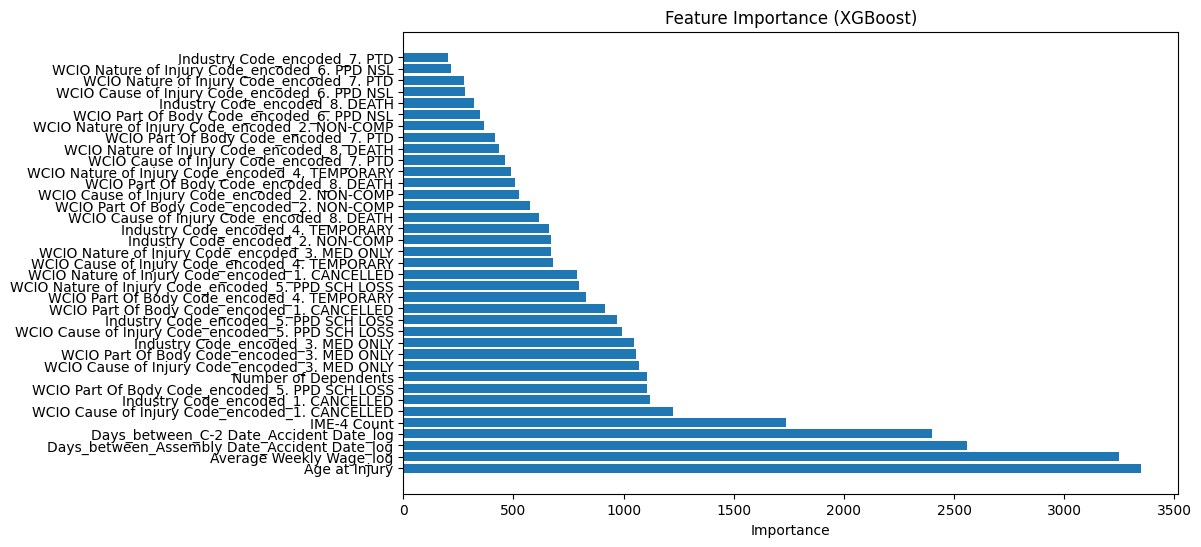

In [9]:
import xgboost as xgb
import pandas as pd

# Train an XGBoost model
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train_num_scaled, y_train_encoded)

# Get feature importances using 'weight' (or you can use 'gain' or 'cover')
feature_importance = model.get_booster().get_score(importance_type='weight')  # Or 'gain' or 'cover'

# Convert the results to a DataFrame
importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(importance_df)

# Optionally, visualize the importance
import matplotlib.pyplot as plt

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost)')
plt.show()


Variance + Mutual Info + Spearman

In [10]:
X_train_num_scaled.var().sort_values(ascending=False)

Average Weekly Wage_log                               0.158004
Industry Code_encoded_5. PPD SCH LOSS                 0.114351
Number of Dependents                                  0.111300
Industry Code_encoded_6. PPD NSL                      0.099752
Industry Code_encoded_8. DEATH                        0.099752
Industry Code_encoded_7. PTD                          0.097456
Industry Code_encoded_2. NON-COMP                     0.097006
Industry Code_encoded_4. TEMPORARY                    0.064015
WCIO Part Of Body Code_encoded_2. NON-COMP            0.057635
WCIO Part Of Body Code_encoded_8. DEATH               0.039938
Industry Code_encoded_3. MED ONLY                     0.039459
WCIO Nature of Injury Code_encoded_4. TEMPORARY       0.039304
Age at Injury                                         0.039004
WCIO Part Of Body Code_encoded_6. PPD NSL             0.038437
WCIO Part Of Body Code_encoded_5. PPD SCH LOSS        0.037588
WCIO Nature of Injury Code_encoded_2. NON-COMP        0

> None have zero variance. Keep all.

In [41]:
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information between categorical features and target
mutual_info = mutual_info_classif(X_train_num_scaled, y_train_encoded)

# Display features sorted by mutual information
mi_results = pd.DataFrame({
    'Feature': X_train_num_scaled.columns,
    'Mutual Information': mutual_info
}).sort_values(by='Mutual Information', ascending=False)

print(mi_results)


                                              Feature  Mutual Information
5                             Average Weekly Wage_log            0.520505
1                                         IME-4 Count            0.218538
22  WCIO Nature of Injury Code_encoded_5. PPD SCH ...            0.110619
24     WCIO Nature of Injury Code_encoded_3. MED ONLY            0.109569
25    WCIO Nature of Injury Code_encoded_4. TEMPORARY            0.108710
23     WCIO Nature of Injury Code_encoded_2. NON-COMP            0.108685
26    WCIO Nature of Injury Code_encoded_1. CANCELLED            0.105062
30     WCIO Part Of Body Code_encoded_5. PPD SCH LOSS            0.104136
33        WCIO Part Of Body Code_encoded_4. TEMPORARY            0.103463
32         WCIO Part Of Body Code_encoded_3. MED ONLY            0.103409
31         WCIO Part Of Body Code_encoded_2. NON-COMP            0.102984
28      WCIO Nature of Injury Code_encoded_6. PPD NSL            0.102317
34        WCIO Part Of Body Code_encod

In [42]:
mi_results

,Feature,Mutual Information
5,Average Weekly Wage_log,0.520505
1,IME-4 Count,0.218538
22,WCIO Nature of Injury Code_encoded_5. PPD SCH ...,0.110619
24,WCIO Nature of Injury Code_encoded_3. MED ONLY,0.109569
25,WCIO Nature of Injury Code_encoded_4. TEMPORARY,0.108710
23,WCIO Nature of Injury Code_encoded_2. NON-COMP,0.108685
26,WCIO Nature of Injury Code_encoded_1. CANCELLED,0.105062
30,WCIO Part Of Body Code_encoded_5. PPD SCH LOSS,0.104136
33,WCIO Part Of Body Code_encoded_4. TEMPORARY,0.103463
32,WCIO Part Of Body Code_encoded_3. MED ONLY,0.103409


In [38]:
import pandas as pd

# Flatten the correlation matrix and reset the index
correlation_pairs = cor_spearman.unstack().reset_index()

# Rename columns for clarity
correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Filter the table for correlations > 0.5 or < -0.5 and exclude self-correlations (diagonal)
strong_correlations = correlation_pairs[
    ((correlation_pairs['Correlation'] > 0.8) | (correlation_pairs['Correlation'] < -0.8)) &
    (correlation_pairs['Feature_1'] != correlation_pairs['Feature_2'])
]

# Drop duplicate pairs (keep unique pairs only)
strong_correlations = strong_correlations.sort_values(by='Correlation', ascending=False).drop_duplicates(subset=['Correlation'])

# Display the table
strong_correlations


,Feature_1,Feature_2,Correlation
118,Days_between_Assembly Date_Accident Date_log,Days_between_C-2 Date_Accident Date_log,0.954048
1290,WCIO Part Of Body Code_encoded_4. TEMPORARY,WCIO Part Of Body Code_encoded_6. PPD NSL,0.811993
587,WCIO Cause of Injury Code_encoded_2. NON-COMP,WCIO Cause of Injury Code_encoded_4. TEMPORARY,-0.820819
235,Industry Code_encoded_5. PPD SCH LOSS,Industry Code_encoded_2. NON-COMP,-0.834529
899,WCIO Nature of Injury Code_encoded_2. NON-COMP,WCIO Nature of Injury Code_encoded_4. TEMPORARY,-0.878413


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeClassifier
import pandas as pd



# Convert the scaled data back to a Pandas DataFrame
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns)

# Initialize the classifier
clf = RidgeClassifier()

# Initialize RFE with the classifier
rfe_selector = RFE(clf, n_features_to_select=10)
rfe_selector.fit(X_train_num_scaled, y_train_encoded)

# Get the selected features
selected_features = X_train_num_scaled.columns[rfe_selector.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['IME-4 Count', 'Days_between_Assembly Date_Accident Date_log',
       'Days_between_C-2 Date_Accident Date_log', 'Average Weekly Wage_log',
       'WCIO Nature of Injury Code_encoded_2. NON-COMP',
       'WCIO Nature of Injury Code_encoded_4. TEMPORARY',
       'WCIO Nature of Injury Code_encoded_1. CANCELLED',
       'WCIO Part Of Body Code_encoded_5. PPD SCH LOSS',
       'WCIO Part Of Body Code_encoded_2. NON-COMP',
       'WCIO Part Of Body Code_encoded_4. TEMPORARY'],
      dtype='object')


In [57]:

# Initialize and train the Logistic Regression model
log_reg_clf = LogisticRegression(max_iter=1000)
log_reg_clf.fit(X_train_num_scaled, y_train_encoded)

# Predict on the validation set
y_pred = log_reg_clf.predict(X_val_num_scaled)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_val_encoded, y_pred)}")
print(classification_report(y_val_encoded, y_pred))

Accuracy: 0.742212543554007


c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.45      0.17      0.25      3741
           2       0.83      0.94      0.88     87319
           3       0.42      0.03      0.05     20672
           4       0.64      0.89      0.74     44551
           5       0.64      0.37      0.47     14484
           6       0.00      0.00      0.00      1263
           7       0.00      0.00      0.00        29
           8       0.50      0.06      0.10       141

    accuracy                           0.74    172200
   macro avg       0.43      0.31      0.31    172200
weighted avg       0.70      0.74      0.69    172200



In [8]:
selector = RFE(clf, n_features_to_select=0.2)  # Select 20% of features
selector.fit(X_train_num_scaled, y_train_encoded)
selected_features = X_train_num_scaled.columns[selector.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['IME-4 Count', 'Days_between_Assembly Date_Accident Date_log',
       'Days_between_C-2 Date_Accident Date_log', 'Average Weekly Wage_log',
       'WCIO Cause of Injury Code_encoded_2. NON-COMP',
       'WCIO Cause of Injury Code_encoded_4. TEMPORARY',
       'WCIO Cause of Injury Code_encoded_1. CANCELLED'],
      dtype='object')


In [7]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeClassifier

# Initialize the classifier (RidgeClassifier handles multiclass)
clf = RidgeClassifier()

# Initialize RFE with the classifier
selector = RFE(clf, n_features_to_select=10)

# Fit RFE
selector.fit(X_train_num_scaled, y_train_encoded)

# Get the selected features
selected_features = X_train_num_scaled.columns[selector.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['IME-4 Count', 'Days_between_Assembly Date_Accident Date_log',
       'Days_between_C-2 Date_Accident Date_log', 'Average Weekly Wage_log',
       'WCIO Cause of Injury Code_encoded_5. PPD SCH LOSS',
       'WCIO Cause of Injury Code_encoded_2. NON-COMP',
       'WCIO Cause of Injury Code_encoded_3. MED ONLY',
       'WCIO Cause of Injury Code_encoded_4. TEMPORARY',
       'WCIO Cause of Injury Code_encoded_1. CANCELLED',
       'WCIO Nature of Injury Code_encoded_1. CANCELLED'],
      dtype='object')


## SELECTED FEATURES

In [ ]:
# Remerge the numerical and categorical features
X_train = pd.concat([X_train_num_scaled[['IME-4 Count', 'Days_between_Acc_Assembyl', 'Age at Injury', 'Average Weekly Wage']], 
                     X_train_cat[['Attorney/Representative', 'C-3 Date', 'First Hearing Date', 'Nature_Injury_Unknown', 'Binary Average Weekly Wage']]], axis=1)

X_val = pd.concat([X_val_num_scaled[['IME-4 Count', 'Days_between_Acc_Assembyl', 'Age at Injury', 'Average Weekly Wage']], 
                   X_val_cat[['Attorney/Representative', 'C-3 Date', 'First Hearing Date', 'Nature_Injury_Unknown', 'Binary Average Weekly Wage']]], axis=1)

X_test = pd.concat([X_test_num_scaled[['IME-4 Count', 'Days_between_Acc_Assembyl', 'Age at Injury', 'Average Weekly Wage']], 
                    X_test_cat[['Attorney/Representative', 'C-3 Date', 'First Hearing Date', 'Nature_Injury_Unknown', 'Binary Average Weekly Wage']]], axis=1)


## OVER AND UNDERSAMPLING

In [41]:
# Assuming y_train is your target variable
target_distribution = y_train.value_counts()

# Display the distribution
print(target_distribution)


Claim Injury Type
2    202245
4    101242
3     47591
5     33513
1      8191
6      2924
8       324
7        67
Name: count, dtype: int64


In [15]:
y_train

,Claim Injury Type
Claim Identifier,
5506797,5. PPD SCH LOSS
5481216,2. NON-COMP
5520188,5. PPD SCH LOSS
5748412,3. MED ONLY
5653867,4. TEMPORARY
...,...
5930802,2. NON-COMP
5757476,2. NON-COMP
5988322,2. NON-COMP


In [23]:
X_resampled_num

,IME-4 Count,Days_between_Acc_Assembyl,Age at Injury,Average Weekly Wage
0,0.000000,0.758523,0.376812,0.000000
1,0.000000,0.669530,0.565217,0.870436
2,0.000000,0.708157,0.507246,0.000000
3,0.000000,0.716502,0.188406,0.000000
4,0.000000,0.550939,0.434783,0.000000
...,...,...,...,...
328099,0.000000,0.930252,0.647640,0.904978
328100,0.192497,0.795346,0.623188,0.888554
328101,0.000000,0.599792,0.648378,0.000000
328102,0.000000,0.498854,0.509539,0.886917


In [22]:
y_resampled

0         1
1         1
2         1
3         1
4         1
         ..
328099    8
328100    8
328101    8
328102    8
328103    8
Name: Claim Injury Type, Length: 328104, dtype: int64

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Split the data into numerical and categorical features
X_train_num = X_train[['IME-4 Count', 'Days_between_Acc_Assembyl', 'Age at Injury', 'Average Weekly Wage']]
X_train_cat = X_train[['Attorney/Representative', 'C-3 Date', 'First Hearing Date', 'Nature_Injury_Unknown', 'Binary Average Weekly Wage']]

# Define the undersampling strategy for majority classes
undersample_strategy = {
    2: 100000,   # NON-COMP: Reduce to 100k
    4: 100000,   # TEMPORARY: Reduce to 100k
    3: 47591,    # MED ONLY: Keep as is
    5: 33513,    # PPD SCH LOSS
    1: 8191,     # CANCELLED
    6: 2924,     # PPD NSL
    8: 324,      # DEATH
    7: 67        # PTD
}

# Apply undersampling to both numerical and categorical features
undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)

# Apply undersampling to numerical features
X_resampled_num, y_resampled = undersampler.fit_resample(X_train_num, y_train_encoded)

# Apply undersampling to categorical features
X_resampled_cat, y_resampled = undersampler.fit_resample(X_train_cat, y_resampled)

# Check the class distribution after undersampling
print("Class distribution after undersampling:", Counter(y_resampled))

# Define SMOTE strategy for oversampling the minority classes
smote_strategy = {
    1: 30000,   # CANCELLED: Oversample to 30k
    6: 10000,   # PPD NSL: Oversample to 10k
    8: 5000,    # DEATH: Oversample to 5k
    7: 2000     # PTD: Oversample to 2k
}

# Apply SMOTE to oversample the minority classes on the numerical features
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_resampled_num, y_resampled = smote.fit_resample(X_resampled_num, y_resampled)

# Apply SMOTE to oversample the minority classes on the categorical features
X_resampled_cat, y_resampled = smote.fit_resample(X_resampled_cat, y_resampled)

# Combine the resampled numerical and categorical features
X_resampled = pd.concat([X_resampled_num, X_resampled_cat], axis=1)

# Check the final class distribution after both undersampling and oversampling
print("Class distribution after SMOTE oversampling:", Counter(y_resampled))

# Optionally, you can also check the final value counts of the target labels
print(y_resampled.value_counts())


Class distribution after undersampling: Counter({2: 100000, 4: 100000, 3: 47591, 5: 33513, 1: 8191, 6: 2924, 8: 324, 7: 67})


ValueError: Found input variables with inconsistent numbers of samples: [292610, 328104]

In [ ]:
# Apply SMOTE to numerical features first
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# Resample numerical features
X_resampled_num, y_resampled = smote.fit_resample(X_train_num, y_train_encoded)

# Apply resampling to categorical features (e.g., undersampling or other strategies)
# Assuming you're using RandomUnderSampler for categorical features
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_resampled_cat, _ = undersampler.fit_resample(X_train_cat, y_resampled)

# Check that the number of rows in both the resampled features and target are consistent
print(X_resampled_num.shape, X_resampled_cat.shape, y_resampled.shape)

# Now concatenate the resampled numerical and categorical features
X_resampled = pd.concat([X_resampled_num, X_resampled_cat], axis=1)


In [11]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Split into numeric and categorical features (you already have these)
X_train_num = X_train[['IME-4 Count', 'Days_between_Acc_Assembyl', 'Age at Injury', 'Average Weekly Wage']]
X_train_cat = X_train[['Attorney/Representative', 'C-3 Date', 'First Hearing Date', 'Nature_Injury_Unknown', 'Binary Average Weekly Wage']]

# Define the oversampler and undersampler
oversample = RandomOverSampler(sampling_strategy=0.1, random_state=42)  # Oversample to 10% of majority class size
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Majority class reduced to 50% of the total

# Oversample the numeric features
X_resampled_num, y_resampled = oversample.fit_resample(X_train_num, y_train)

# Oversample the categorical features
X_resampled_cat, y_resampled = oversample.fit_resample(X_train_cat, y_train)

# Combine resampled numeric and categorical features back into one dataset
X_resampled = pd.concat([X_resampled_num, X_resampled_cat], axis=1)

# Optionally, apply undersampling after oversampling if you need further balance
X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)

# Check the class distribution after resampling
print("Class distribution after oversampling and undersampling:", Counter(y_resampled))


ValueError: "sampling_strategy" can be a float only when the type of target is binary. For multi-class, use a dict.

In [9]:
# Split into numeric and categorical features
X_train_num = X_train[['IME-4 Count', 'Days_between_Acc_Assembyl', 'Age at Injury', 'Average Weekly Wage']]
X_train_cat = X_train[['Attorney/Representative', 'C-3 Date', 'First Hearing Date', 'Nature_Injury_Unknown', 'Binary Average Weekly Wage']]

# Combine them after resampling if desired
X_resampled_num, y_resampled = oversample.fit_resample(X_train_num, y_train)  # Resample numeric features
X_resampled_cat, y_resampled = oversample.fit_resample(X_train_cat, y_train)  # Resample categorical features

# Combine back into a single dataset
X_resampled = pd.concat([X_resampled_num, X_resampled_cat], axis=1)


NameError: name 'X_train' is not defined

## 4. Model building

> Não está em 1-D o y

In [27]:
y_train = y_train_encoded
y_val = y_val_encoded

In [28]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

# Define the models
models = {
    "MLPClassifier": MLPClassifier(max_iter=500),
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=500),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "GaussianNB": GaussianNB(),
    "RidgeClassifier": RidgeClassifier()
}

# Dictionary to store evaluation results
results = {}

# Iterate over each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the validation data
    y_pred = model.predict(X_val)
    
    # Evaluate the model
    accuracy = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')  # Macro-averaged F1 score
    
    # Store results
    results[model_name] = {
        "accuracy": accuracy,
        "f1_macro": f1_macro
    }
    
    # Print individual model results
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Macro F1 Score: {f1_macro:.4f}")
    print(classification_report(y_val, y_pred))  # Detailed report including precision, recall, and F1 score per class
    print("-" * 50)

# Display the summary of results
print("\nModel Evaluation Results Summary:")
for model_name, metrics in results.items():
    print(f"{model_name}: Accuracy = {metrics['accuracy']:.4f}, Macro F1 Score = {metrics['f1_macro']:.4f}")


Training MLPClassifier...
MLPClassifier Accuracy: 0.7620
MLPClassifier Macro F1 Score: 0.3318


c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.63      0.31      0.42      3741
           2       0.83      0.98      0.90     87319
           3       0.47      0.05      0.08     20672
           4       0.68      0.85      0.76     44551
           5       0.59      0.42      0.49     14484
           6       0.00      0.00      0.00      1263
           7       0.00      0.00      0.00        29
           8       0.25      0.01      0.01       141

    accuracy                           0.76    172200
   macro avg       0.43      0.33      0.33    172200
weighted avg       0.72      0.76      0.71    172200

--------------------------------------------------
Training RandomForest...
RandomForest Accuracy: 0.7392
RandomForest Macro F1 Score: 0.3384
              precision    recall  f1-score   support

           1       0.45      0.33      0.38      3741
           2       0.84      0.95      0.89     87319
           3       0.26      0.09      0.14 

c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.56      0.26      0.36      3741
           2       0.83      0.93      0.88     87319
           3       0.35      0.05      0.09     20672
           4       0.61      0.88      0.72     44551
           5       0.49      0.20      0.29     14484
           6       0.00      0.00      0.00      1263
           7       0.00      0.00      0.00        29
           8       0.00      0.00      0.00       141

    accuracy                           0.73    172200
   macro avg       0.36      0.29      0.29    172200
weighted avg       0.68      0.73      0.67    172200

--------------------------------------------------
Training KNeighborsClassifier...
KNeighborsClassifier Accuracy: 0.7318
KNeighborsClassifier Macro F1 Score: 0.3284


c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.48      0.35      0.41      3741
           2       0.83      0.95      0.89     87319
           3       0.25      0.10      0.14     20672
           4       0.67      0.77      0.72     44551
           5       0.51      0.37      0.43     14484
           6       0.09      0.00      0.01      1263
           7       0.00      0.00      0.00        29
           8       0.12      0.02      0.04       141

    accuracy                           0.73    172200
   macro avg       0.37      0.32      0.33    172200
weighted avg       0.68      0.73      0.70    172200

--------------------------------------------------
Training DecisionTree...
DecisionTree Accuracy: 0.6987
DecisionTree Macro F1 Score: 0.3238
              precision    recall  f1-score   support

           1       0.37      0.34      0.36      3741
           2       0.84      0.94      0.89     87319
           3       0.20      0.12      0.15 

c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.38      0.55      0.45      3741
           2       0.88      0.85      0.86     87319
           3       0.25      0.05      0.08     20672
           4       0.67      0.37      0.47     44551
           5       0.49      0.32      0.39     14484
           6       0.00      0.00      0.00      1263
           7       0.00      0.90      0.00        29
           8       0.01      0.84      0.02       141

    accuracy                           0.57    172200
   macro avg       0.33      0.48      0.28    172200
weighted avg       0.70      0.57      0.61    172200

--------------------------------------------------
Training RidgeClassifier...
RidgeClassifier Accuracy: 0.7263
RidgeClassifier Macro F1 Score: 0.2426


c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.56      0.19      0.29      3741
           2       0.83      0.94      0.88     87319
           3       0.00      0.00      0.00     20672
           4       0.59      0.94      0.72     44551
           5       0.45      0.03      0.05     14484
           6       0.00      0.00      0.00      1263
           7       0.00      0.00      0.00        29
           8       0.00      0.00      0.00       141

    accuracy                           0.73    172200
   macro avg       0.30      0.26      0.24    172200
weighted avg       0.62      0.73      0.64    172200

--------------------------------------------------

Model Evaluation Results Summary:
MLPClassifier: Accuracy = 0.7620, Macro F1 Score = 0.3318
RandomForest: Accuracy = 0.7392, Macro F1 Score = 0.3384
LogisticRegression: Accuracy = 0.7264, Macro F1 Score = 0.2914
KNeighborsClassifier: Accuracy = 0.7318, Macro F1 Score = 0.3284
DecisionTree: Accura

c:\Users\emano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
